# Stellar Hosts Data

All data from NASAs Steller Hosts database DOI: 10.26133/NEA40

In [1]:
from astroquery.utils.tap.core import TapPlus
from io import StringIO
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

- TapPlus - required to make Tap requests to NASA's astronomical database ot get the stellar hosts table
- StringIO - use to use Tap VOTable result as a tempory file so it can be read and saved as a .csv file
- plt - to create visual plots for the data
- pd - create pandas databases and dataframes
- np - to work with the pandas dataframe   

In [10]:
# check the schema of the data, as there are 134 columns I've saved the data as a csv file for easier referal/reading to see what data I would like to work with
tap_service = TapPlus(url="https://exoplanetarchive.ipac.caltech.edu/TAP")
query = "SELECT * FROM TAP_SCHEMA.columns WHERE table_name LIKE 'stellarhosts'"
job = tap_service.launch_job_async(query)

result_csv = job.get_results().to_pandas().to_csv(index=False)
stellar_hosts_schema = pd.read_csv(StringIO(result_csv))
stellar_hosts_schema.to_csv('stellar_hosts_schema.csv', index=False)

INFO: Query finished. [astroquery.utils.tap.core]


> ^ Above
Used to save a .csv of the stellar hosts table schema as there is over 100 columns to the table.
is allows us to decide what information is important to us for the sake of our program.

In [25]:
# make spefic query for the specific columns wanted 
tap_service = TapPlus(url="https://exoplanetarchive.ipac.caltech.edu/TAP")
query = "SELECT sy_name, sy_snum, sy_pnum FROM stellarhosts"
job = tap_service.launch_job_async(query)

# save stellar_hosts as dataframe and file for reference 
result_csv = job.get_results().to_pandas().to_csv(index=False)
stellar_hosts = pd.read_csv(StringIO(result_csv))
stellar_hosts.to_csv('stell_hosts.csv', index=False)

INFO: Query finished. [astroquery.utils.tap.core]


> ^ Above: Used to save the desired column data from the stellar hosts VOTable file data to a Pandas database to then also save as a .csv for reference.

In [36]:
stellar_hosts.sy_name.count().sum()

np.int64(4300)

> ^ Above: see how many rows of data are in the database... this can be repeatable when running changes over the database (such as removing duplicates).

In [30]:
stellar_hosts = stellar_hosts.sort_values(by=['sy_name'])
stellar_hosts.to_csv('stell_hosts.csv', index=False)

> ^ Above: organise pandas database by sy_name (system name).

In [35]:
# look over the data dase by the system names and see if there are duplicate columns
duplicates = stellar_hosts.duplicated(subset=['sy_name'], keep='first')
# as duplicates is a boolean series running .sum() will count every True value as Trues will be 1 and False's will be 0.
print(f"Number of non-duplicate systems: {stellar_hosts.sy_name.count().sum() - duplicates.sum()}")
print(f"Number of duplicate systems: {duplicates.sum()}")

Number of non-duplicate systems: 4300
Number of duplicate systems: 0


> ^ Above: there are a lot of duplicate systems as the database is a record od all planetary/star data, so the data we will be using is much smaller than the origional database

In [34]:
stellar_hosts = stellar_hosts.drop_duplicates()

> ^ Above: drop duplicate data from database as it contains dulplicate data for what we are looking into, the database has data for every star and planet, but we are wanting to look at the data by system. By dropping duplicates we are dropping any duplicate systems...

> [!NOTE] 
> At this point we will want to re-run the .count().sum() function above to see if the data has been removed.

In [37]:
stellar_hosts.to_csv('stell_hosts.csv', index=False)

> ^ Above: re-writing the stellar_hosts.csv file to represent the database we are currently working with.

In [75]:
stellar_df = pd.DataFrame(stellar_hosts)

grouped = stellar_df.groupby(['sy_snum', 'sy_pnum']).size().unstack(fill_value=0)

print(grouped)
# print(stellar_df)

sy_pnum     1    2    3   4   5  6  7  8
sy_snum                                 
1        3032  594  189  65  23  9  1  1
2         266   41   18   9   3  1  0  0
3          37    5    0   1   2  1  0  0
4           2    0    0   0   0  0  0  0


In [86]:
indices = np.arange(len(grouped))
print(indices)
print(len(grouped))

[0 1 2 3]
4


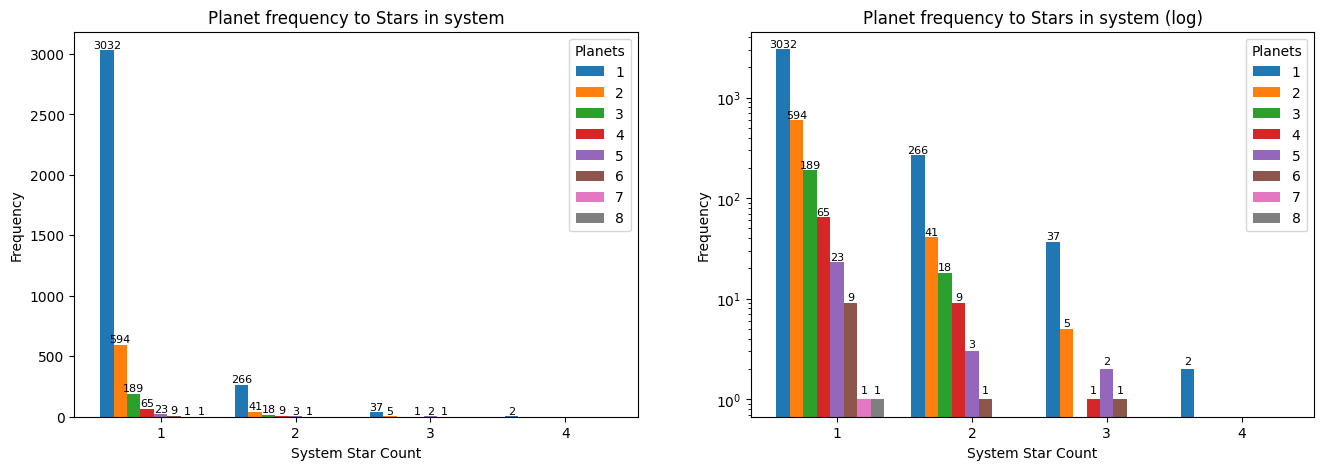

In [88]:
stellar_df = pd.DataFrame(stellar_hosts)

grouped = stellar_df.groupby(['sy_snum', 'sy_pnum']).size().unstack(fill_value=0)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

bar_width = 0.1
indices = np.arange(len(grouped))

i = 0
while i < 2:
    for j, sy_pnum_val in enumerate(grouped.columns):
        # label = creates the planets 1-8 side labels legend
        bars = ax[i].bar(x=indices + j * bar_width, height=grouped[sy_pnum_val], width=bar_width, label=f'{sy_pnum_val}')

        # print frequency values atop the bars
        for bar in bars:
            yval = bar.get_height()
            if yval > 0:
                ax[i].text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom', fontsize=8)
    i += 1

ax[0].set_xlabel('System Star Count')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Planet frequency to Stars in system')
ax[0].set_xticks(indices + bar_width * 4)
ax[0].set_xticklabels(grouped.index)
ax[0].legend(title='Planets')


ax[1].set_yscale('log')
ax[1].set_xlabel('System Star Count')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Planet frequency to Stars in system (log)')
ax[1].set_xticks(indices + bar_width * 4)
ax[1].set_xticklabels(grouped.index)
ax[1].legend(title='Planets')

plt.show()

> ^ Above: creates side by side representations of planet frequency to singluar star systems and binary star systems. One is an actual visual representation of the frequencies in relation to one another and the other is a log representaion to make the results more readable as there is great variance of the data 